# __Text Classification Using RNN__

Let's see how to classify the text using RNN (Recurrent Neural Network).

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Steps to be followed:

1. Import the libraries
2. Define the hyperparameter
3. Preprocess the data and print the lengths of the labels and article lists
4. Split the data into training and validation sets
5. Initialize a tokenizer and fit it to the training articles
6. Convert the training articles into sequences using the tokenizer
7. Pad the sequence
8. Print the length of validation sequences and the shape of validation padded
9. Train the model
10. Compile the model
11. Plot the graph

### Step 1: Import the libraries
- Import the required libraries.

In [2]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
import matplotlib.pyplot as plt


### Step 2: Define the hyperparameter
- Set the value of __vocab_size__ to __5000__, representing the size of the vocabulary.
- Set the value of __embedding_dim__ to __64__, specifying the dimensionality of the word embeddings.
- Set the value of __max_length__ to __200__, indicating the maximum length of input sequences.
- Set the value of __padding_type__ to __post__, specifying that padding should be added at the end of sequences.
- Set the value of __trunc_type__ to __post__, indicating that truncation should be applied at the end of sequences.
- Set the value of __oov_tok__ to __OOV__, representing the token to be used for out-of-vocabulary words.
- Set the value of __training_portion__ to __0.8__, representing the proportion of data to be used for training.

In [3]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
padding_type = 'post'
trunc_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

### Step 3: Preprocess the data and print the lengths of the labels and articles lists

- Define two empty lists, articles, and labels to store the articles and labels, respectively.
- Read the contents of the **bbc-text.csv** file using csv.reader and iterate through each row.
- Extract the labels from the first column of each row and append it to the labels list.
- Process the article from the second column by removing stopwords and replacing consecutive spaces with a single space, and then append it to the article list.
- Print the lengths of the labels and article lists to display the number of labels and processed articles, respectively.

In [4]:
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # skip header
    for row in reader:
        label, article = row
        article = ' '.join([word for word in article.split() if word not in STOPWORDS])
        articles.append(article)
        labels.append(label)
print(len(labels))
print(len(articles))

FileNotFoundError: [Errno 2] No such file or directory: 'bbc-text.csv'

__Observations:__
- There are only **2,225** articles in the data.
- Then, we split into a training set and a validation set, according to the parameter we set earlier, 80% for training, and 20% for validation.

### Step 4: Split the data into training and validation sets
- Calculate the **train_size** by multiplying the length of the article list with __training_portion__ and converting it to an integer.
- Create **train_articles** by slicing the article list from index **0** to **train_size.**
- Create **train_labels** by slicing the labels list from index **0** to **train_size.**
- Create validation_articles by slicing the articles list from **train_size** onward.
- Create **validation_labels** by slicing the labels list from **train_size** onward.
- Print the **train_size** to display the calculated value.

- The lengths of **train_articles**, **train_labels**, **validation_articles**, and **validation_labels** represent the number of items in each list.

In [ ]:
print(set(labels))

{'sport', 'entertainment', 'politics', 'business', 'tech'}


__Observation:__

- The output is a set containing the unique labels: 'business', 'tech', 'entertainment', 'politics', and 'sport'.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert labels to integers using LabelEncoder which automatically makes them 0-indexed
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [ ]:
# Check unique labels and adjust the model's last Dense layer
num_classes = len(np.unique(labels_encoded))
print("Number of unique labels:", num_classes)


Number of unique labels: 5


In [ ]:
# Split the data
train_size = int(len(articles) * training_portion)
train_articles = articles[:train_size]
training_label_seq = labels_encoded[:train_size]

validation_articles = articles[train_size:]
validation_label_seq = labels_encoded[train_size:]


print(train_size)
print(len(train_articles))
print(len(training_label_seq))
print(len(validation_articles))
print(len(validation_label_seq))

1780
1780
1780
445
445


__Observations:__
- The value of **train_size** is calculated based on the proportion of training data.
- The lengths of **train_articles**, **training_label_seq**, **validation_articles**, and **validation_label_seq** represent the number of items in each list.

### Step 5: Initialize a tokenizer and fit it to the training articles

- Initialize a **Tokenizer** object named tokenizer with the specified parameters: **num_words** representing the vocabulary size and **oov_token** representing the out-of-vocabulary token.
- Fit the tokenizer on the training articles **(train_articles)** using the **fit_on_texts** method.

  `fit_on_texts`: Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it a sample sentence like

    `The cat sat on the mat.`

  It will create a dictionary, where every word gets a unique integer value. 0 is reserved for padding.
      word_index["the"] = 1; word_index["cat"] = 2.

- This step updates the tokenizer's internal word index based on the words in the training articles.
- Assign the word index obtained from the tokenizer to the variable **word_index.**
- Extract the first 10 items from the word_index dictionary
- Print the resulting dictionary.

In [ ]:
# Initialize and fit tokenizer on training data only
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [ ]:
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'would': 4,
 'year': 5,
 'also': 6,
 'people': 7,
 'new': 8,
 'us': 9,
 'one': 10}

__Observations:__
- The code prints a dictionary containing the first 10 items from the word_index dictionary.
- These items represent a subset of the word-to-index mappings generated by the tokenizer.

### Step 6: Convert the training articles into sequences using the tokenizer
- Convert the training articles **(train_articles)** into sequences of numbers using the `texts_to_sequences` method of the tokenizer object and assign the result to `train_sequences` variable
    
- Print the sequence representation of the 11th training article (index 10) by accessing **train_sequences[10].**

In [ ]:
train_sequences  = tokenizer.texts_to_sequences(train_articles)

# train_sequences is a list of lists
print(train_sequences[10])

[2430, 1, 225, 4991, 22, 641, 586, 225, 4991, 1, 1, 1660, 1, 1, 2430, 22, 564, 1, 1, 140, 278, 1, 140, 278, 796, 822, 661, 2305, 1, 1144, 1691, 1, 1718, 4992, 1, 1, 1, 1, 1, 4733, 1, 1, 122, 4510, 1, 2, 2873, 1503, 352, 4734, 1, 52, 341, 1, 352, 2170, 3958, 41, 22, 3792, 1, 1, 1, 1, 542, 1, 1, 1, 834, 631, 2365, 347, 4735, 1, 365, 22, 1, 787, 2366, 1, 4298, 138, 10, 1, 3663, 681, 3531, 1, 22, 1, 414, 822, 661, 1, 90, 13, 633, 1, 225, 4991, 1, 598, 1, 1691, 1021, 1, 4993, 807, 1861, 117, 1, 1, 1, 2973, 22, 1, 99, 278, 1, 1604, 4994, 542, 492, 1, 1441, 4736, 778, 1319, 1, 1858, 10, 33, 641, 319, 1, 62, 478, 564, 301, 1504, 22, 479, 1, 1, 1663, 1, 797, 1, 3065, 1, 1363, 6, 1, 2430, 564, 22, 2970, 4730, 1, 1, 1, 1, 1, 850, 39, 1822, 674, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1504, 1341, 374, 20, 63, 883, 1096, 4299, 247]


__Observation:__
- The code prints the sequence representation of the 11th training article (index 10) in the **train_sequences** list.
- The output is a list of integers, where each integer represents the index of a word in the tokenizer's word index vocabulary that corresponds to a word in the article.

### Step 7: Pad the Sequence
- Pad the sequences in **train_sequences** using the **pad_sequences** function. It is done so that every sequence has the same length.
- Set the maximum length of the padded sequences to **max_length.**
- Specify the padding type as **padding_type** and the truncation type as **trunc_type.**
- Assign the padded sequences to the variable **train_padded.**

In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
print(train_padded[10])

[2432    1  225 4996   22  641  587  225 4996    1    1 1662    1    1
 2432   22  564    1    1  140  278    1  140  278  796  822  662 2308
    1 1145 1693    1 1720 4997    1    1    1    1    1 4739    1    1
  122 4515    1    2 2874 1506  352 4740    1   52  341    1  352 2173
 3962   41   22 3796    1    1    1    1  542    1    1    1  835  631
 2367  347 4741    1  365   22    1  787 2368    1 4303  138   10    1
 3666  682 3533    1   22    1  414  822  662    1   90   13  633    1
  225 4996    1  599    1 1693 1021    1 4998  807 1863  117    1    1
    1 2974   22    1   99  278    1 1607 4999  542  492    1 1444 4742
  778 1320    1 1860   10   33  641  319    1   62  478  564  301 1507
   22  479    1    1 1665    1  797    1 3067    1 1365    6    1 2432
  564   22 2971 4736    1    1    1    1    1  850   39 1824  675  297
   26  979    1  882   22  361   22   13  301 1507 1343  374   20   63
  883 1097 4304  247    0    0    0    0    0    0    0    0    0    0
    0 

__Observation:__
- The code prints the padded sequence representation of the 11th training article.
- The output is a list of integers representing the word indices of the corresponding words in the article, after applying padding to ensure a consistent length (max_length) for all sequences.

### Step 8: Print the length of validation sequences and the shape of validation padded
- Convert the validation articles into sequences using the tokenizer and pad the sequences to a maximum length. Assign the result to **validation_padded.**
- Print the length of **validation_sequences** and the shape of **validation_padded.**
- Create a tokenizer for the labels and fit it on the labels list.
- Convert the training and validation labels into sequences using the label tokenizer and store the results in **training_label_seq** and **validation_label_seq** as NumPy arrays.

In [ ]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)


445
(445, 200)


__Observations:__
- The length of **validation_sequences**, indicating the number of sequences in the validation set.
- The shape of **validation_padded**, representing the dimensions of the padded validation sequences.

In [ ]:
# Confirm that labels are correctly zero-indexed
print("Unique training labels:", np.unique(training_label_seq))
print("Unique validation labels:", np.unique(validation_label_seq))

Unique training labels: [0 1 2 3 4]
Unique validation labels: [0 1 2 3 4]


### Step 9: Train the model
- Create a sequential model using **tf.keras.Sequential().**
- Add an embedding layer to the model with the specified vocabulary size **(vocab_size)** and embedding dimension **(embedding_dim).**
- Add a bidirectional SimpleRNN layer to the model with the same embedding dimension.
- Add a dense layer to the model with the embedding dimension as the number of units and **relu** activation function.
- Add a dense layer with `num_classes` which represents the number of unique classes/labels and the **softmax** activation function to the model.
- Print a summary of the model's architecture using **model.summary().**

In [ ]:
# Create and compile the model.
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               16512     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 345093 (1.32 MB)
Trainable params: 345093 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


__Observation:__
- The code outputs a summary of the model's architecture, including the number of parameters and the shape of each layer in the model.

### Step 10: Compile the model
- Compile the model using **model.compile()** with the loss function set to **sparse_categorical_crossentropy**, the optimizer set to **adam**, and the metrics set to **accuracy.**
- Set the number of epochs to 10.
- Train the model using **model.fit()** with the training padded sequences **(train_padded)** and training label sequences **(training_label_seq).**
- Specify the number of epochs as **num_epochs**, the validation data as the validation padded sequences **(validation_padded)** and validation label sequences **(validation_label_seq)**, and **verbose** mode as **2.**

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
num_epochs = 10

history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)


Epoch 1/10
56/56 - 8s - loss: 1.5367 - accuracy: 0.2944 - val_loss: 1.4310 - val_accuracy: 0.3708 - 8s/epoch - 145ms/step
Epoch 2/10
56/56 - 7s - loss: 1.2992 - accuracy: 0.4652 - val_loss: 1.4219 - val_accuracy: 0.3618 - 7s/epoch - 132ms/step
Epoch 3/10
56/56 - 6s - loss: 0.8730 - accuracy: 0.7376 - val_loss: 0.9964 - val_accuracy: 0.5843 - 6s/epoch - 100ms/step
Epoch 4/10
56/56 - 8s - loss: 0.2204 - accuracy: 0.9506 - val_loss: 0.7974 - val_accuracy: 0.7011 - 8s/epoch - 136ms/step
Epoch 5/10
56/56 - 5s - loss: 0.0314 - accuracy: 0.9983 - val_loss: 0.8392 - val_accuracy: 0.6697 - 5s/epoch - 94ms/step
Epoch 6/10
56/56 - 6s - loss: 0.0729 - accuracy: 0.9944 - val_loss: 0.9877 - val_accuracy: 0.6472 - 6s/epoch - 110ms/step
Epoch 7/10
56/56 - 6s - loss: 0.0099 - accuracy: 1.0000 - val_loss: 1.0919 - val_accuracy: 0.6315 - 6s/epoch - 110ms/step
Epoch 8/10
56/56 - 5s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.0796 - val_accuracy: 0.6337 - 5s/epoch - 94ms/step
Epoch 9/10
56/56 - 7s - lo

__Observations:__
- The code trains the model for the specified number of epochs and records the training and validation accuracy and loss metrics.
- The output is an object named history that contains information about the training process, such as the loss and accuracy values at each epoch.

### Step 11: Plot the Graph
- Define a function named **plot_graphs** that takes history and strings as inputs. Inside the function, plot the training and validation values of the given metric (string) from the history object using **plt.plot().**
- Set the x-axis labels as **Epochs** and the y-axis labels as the given metric (string).
- Call the **plot_graphs** function twice, first with **history** and **accuracy** as arguments, and then with **history** and **loss** as arguments.
- Display the generated plots showing the training and validation values of the accuracy and loss metrics over the epochs.

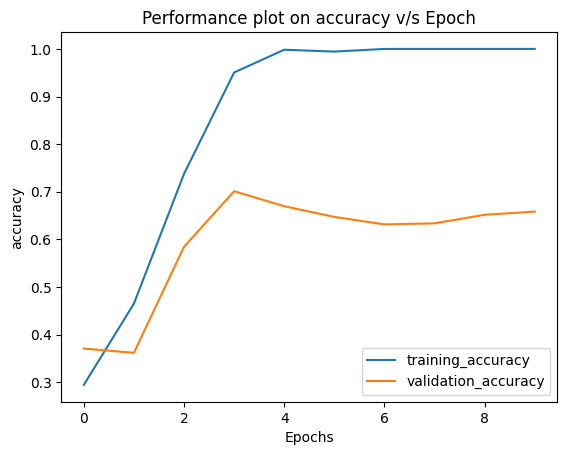

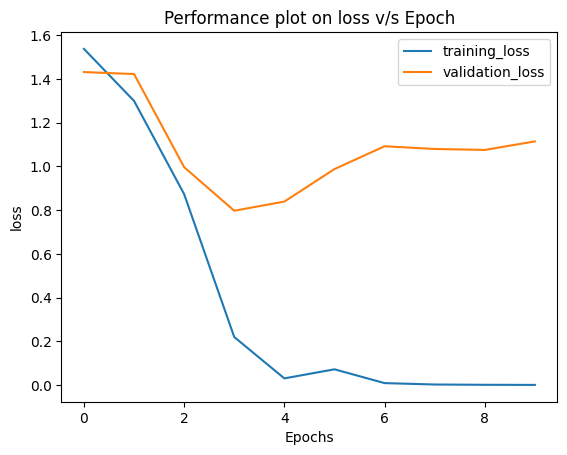

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title("Performance plot on "+string+" v/s Epoch")
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend(['training_'+string, 'validation_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**Observation**

The generated plots illustrate the training and validation accuracy and loss metrics over the epochs, providing a visual representation of the model's performance. This helps identify trends and potential overfitting or underfitting in the training process.

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_padded, validation_label_seq, verbose=2)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")

14/14 - 1s - loss: 1.1142 - accuracy: 0.6584 - 588ms/epoch - 42ms/step
Validation loss: 1.1141722202301025
Validation accuracy: 0.6584269404411316


In [ ]:
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(train_padded, training_label_seq, verbose=2)
print(f"Training loss: {train_loss}")
print(f"Training accuracy: {train_accuracy}")

56/56 - 3s - loss: 0.0013 - accuracy: 1.0000 - 3s/epoch - 52ms/step
Training loss: 0.0013326754560694098
Training accuracy: 1.0


**Analysis of Results**

- Perfect Training Accuracy: A training accuracy of 100% suggests that the model has perfectly learned or memorized the training data. This is usually an indication of overfitting, where the model is tailored so closely to the training data that it fails to generalize well to new data.

- High Validation Loss: The considerably higher validation loss compared to the training loss further supports the possibility of overfitting. A high validation loss means the model does not perform well on data it hasn't seen before, which is crucial for practical applications.

- Moderate Validation Accuracy: The validation accuracy is significantly lower than the training accuracy

#### __Steps to Address Overfitting__

To improve the model's generalization capabilities, consider the following strategies:

1. Regularization: Implement regularization techniques such as L1 or L2 regularization, which add a penalty on the size of the coefficients.

2. Dropout: Introduce dropout layers in your network. Dropout is a form of regularization that randomly sets the output features of hidden units to zero during training with a certain probability (commonly 0.5 for hidden layers).

3. Model Simplification: Reduce the complexity of the model by using fewer layers or hidden units. Simpler models are less likely to overfit.

4. Early Stopping: Use early stopping during training. This technique stops training as soon as the validation performance begins to deteriorate, regardless of the training performance.

5. Data Augmentation: Increase the diversity of the training data through data augmentation techniques, if applicable. This is more common in tasks involving images or audio but can sometimes be adapted to text data.

6. Increase Data Size: If feasible, increase the size of the training dataset. Models trained on more data are generally more robust and generalize better.

7. Cross-Validation: Implement k-fold cross-validation to ensure that the model’s evaluation is robust and consistent across different subsets of the dataset.

Let us introduce dropout layers to the current model and see if metrices are improving or not:

In [ ]:
model_dropout = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(embedding_dim)),
    tf.keras.layers.Dropout(0.5),  # Add dropout
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add another dropout layer
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_dropout.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model_dropout.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)


Epoch 1/10
56/56 - 8s - loss: 1.6229 - accuracy: 0.2213 - val_loss: 1.5246 - val_accuracy: 0.3281 - 8s/epoch - 144ms/step
Epoch 2/10
56/56 - 7s - loss: 1.4694 - accuracy: 0.3730 - val_loss: 1.3974 - val_accuracy: 0.4404 - 7s/epoch - 126ms/step
Epoch 3/10
56/56 - 5s - loss: 1.4131 - accuracy: 0.4275 - val_loss: 1.4270 - val_accuracy: 0.4045 - 5s/epoch - 92ms/step
Epoch 4/10
56/56 - 6s - loss: 0.9894 - accuracy: 0.6343 - val_loss: 0.9657 - val_accuracy: 0.6022 - 6s/epoch - 108ms/step
Epoch 5/10
56/56 - 6s - loss: 0.5695 - accuracy: 0.8180 - val_loss: 0.9260 - val_accuracy: 0.6315 - 6s/epoch - 110ms/step
Epoch 6/10
56/56 - 6s - loss: 0.2906 - accuracy: 0.9208 - val_loss: 0.8247 - val_accuracy: 0.6562 - 6s/epoch - 105ms/step
Epoch 7/10
56/56 - 9s - loss: 0.1584 - accuracy: 0.9624 - val_loss: 0.7523 - val_accuracy: 0.7236 - 9s/epoch - 157ms/step
Epoch 8/10
56/56 - 5s - loss: 0.0750 - accuracy: 0.9876 - val_loss: 0.7401 - val_accuracy: 0.7596 - 5s/epoch - 97ms/step
Epoch 9/10
56/56 - 7s - lo

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model_dropout.evaluate(validation_padded, validation_label_seq, verbose=2)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")

14/14 - 0s - loss: 0.7693 - accuracy: 0.7663 - 370ms/epoch - 26ms/step
Validation loss: 0.7692967057228088
Validation accuracy: 0.766292154788971


In [ ]:
# Evaluate the model on the training set
train_loss, train_accuracy = model_dropout.evaluate(train_padded, training_label_seq, verbose=2)
print(f"Training loss: {train_loss}")
print(f"Training accuracy: {train_accuracy}")

56/56 - 4s - loss: 0.0013 - accuracy: 1.0000 - 4s/epoch - 70ms/step
Training loss: 0.0013346042251214385
Training accuracy: 1.0


__Observation__

Here, you can see that the validation accuracy has increased to ~77%

Now lets explore one more step to address overfitting called **Early Stopping**

**Explanation of Early Stopping Parameters:**

`monitor`: This is the metric to be monitored, usually 'val_loss' or 'val_accuracy'.

`patience`: The number of epochs to continue training without improvement in the monitored metric. After this number, training stops.

`restore_best_weights`: When set to True, the model weights are reverted to those that achieved the best value of the monitored metric. This is useful because even after the condition for patience is met, the best model may have occurred in an earlier epoch.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Configure early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Fit the model with dropout layer, with early stopping
num_epochs = 10
history = model_dropout.fit(
    train_padded,
    training_label_seq,
    epochs=num_epochs,
    validation_data=(validation_padded, validation_label_seq),
    verbose=2,
    callbacks=[early_stopping]  # Add early stopping to callbacks
)


Epoch 1/10
56/56 - 6s - loss: 0.1988 - accuracy: 0.9365 - val_loss: 0.5597 - val_accuracy: 0.8315 - 6s/epoch - 101ms/step
Epoch 2/10
56/56 - 5s - loss: 0.0814 - accuracy: 0.9736 - val_loss: 0.7404 - val_accuracy: 0.8090 - 5s/epoch - 92ms/step
Epoch 3/10
56/56 - 7s - loss: 0.0453 - accuracy: 0.9854 - val_loss: 0.8356 - val_accuracy: 0.7775 - 7s/epoch - 129ms/step
Epoch 4/10
56/56 - 5s - loss: 0.0362 - accuracy: 0.9860 - val_loss: 0.7233 - val_accuracy: 0.8090 - 5s/epoch - 94ms/step


In [ ]:
# Evaluate model performance
val_loss, val_accuracy = model_dropout.evaluate(validation_padded, validation_label_seq, verbose=2)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")


14/14 - 0s - loss: 0.5597 - accuracy: 0.8315 - 310ms/epoch - 22ms/step
Validation loss: 0.5597330331802368
Validation accuracy: 0.8314606547355652


__Observation__

- Before adding dropout and early stopping, the validation accuracy was around 65.84%. After these adjustments, it has improved significantly to 83.15%.
The training accuracy previously was 100%, indicating overfitting.

- With early stopping and dropout, this perfect score likely dropped (though you haven't provided the new training accuracy), which is actually beneficial in terms of reducing overfitting.